In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/housesalesprediction/kc_house_data.csv


In [38]:
from matplotlib import pyplot as plt
import seaborn as sns
house = pd.read_csv('/kaggle/input/housesalesprediction/kc_house_data.csv')
house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Performing the train test split will ensure that our analyses are not biased in favor of predicting the house prices in the test set. We want to ensure that we can accurately and reliably evaluate the performance of our linear regression model.

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(house, test_size=0.33, random_state=42) #2/3 training and 1/3 testing

# Exploratory Data Analysis Phase

In [40]:
print(house.columns)
len(house.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


21

There are 20 features and one label, the price of the house

In [41]:
[type(X_train[column].iloc[0]) for column in X_train.columns]

[numpy.int64,
 str,
 numpy.float64,
 numpy.int64,
 numpy.float64,
 numpy.int64,
 numpy.int64,
 numpy.float64,
 numpy.int64,
 numpy.int64,
 numpy.int64,
 numpy.int64,
 numpy.int64,
 numpy.int64,
 numpy.int64,
 numpy.int64,
 numpy.int64,
 numpy.float64,
 numpy.float64,
 numpy.int64,
 numpy.int64]

It appears to be that the majority of the feature columns are associated with quantitative discrete values, with some quantitative continuous values. However, although zipcode, and id are quantitative discrete, they don't provide valuable information for predicting house prices. Nor does the date column provide any useful information. Thus, we will drop these columns.

In [42]:
X_train = X_train.drop(columns = ['id', 'date', 'zipcode'])

Some variables of interest include waterfront and view, which may include binary values 0 or 1. Let's confirm that

In [43]:
X_train['waterfront'].value_counts()

0    14380
1      100
Name: waterfront, dtype: int64

In [44]:
X_train['view'].value_counts()

0    13060
2      649
3      341
1      230
4      200
Name: view, dtype: int64

Are homes with waterfront and or view more expensive on average?

In [45]:
grouped_by_price_waterfront = X_train[['waterfront', 'price']].groupby('waterfront', as_index = False).agg(np.mean)
grouped_by_price_waterfront

,waterfront,price
0,0,5.307446e+05
1,1,1.550785e+06


In [46]:
ratio_waterfront = grouped_by_price_waterfront['price'].iloc[1]/grouped_by_price_waterfront['price'].iloc[0]
ratio_waterfront

2.921904458494815

Based on the data, it appears that homes with a waterfront are on average three times more expensive than homes without waterfronts. It is important to note that there are only 100 out of the 14,480 homes in the training dataset, so we must proceed with caution.

In [47]:
grouped_by_price_view = X_train[['view', 'price']].groupby('view', as_index = False).agg(np.mean)
grouped_by_price_view

,view,price
0,0,4.959868e+05
1,1,7.982802e+05
2,2,7.881587e+05
3,3,9.869112e+05
4,4,1.389709e+06


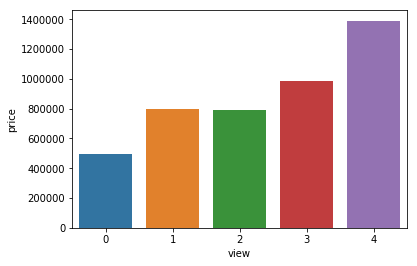

In [48]:
sns.barplot(grouped_by_price_view['view'], grouped_by_price_view['price'])

This basic barplot visualization demonstrates that as the view increases from 1 to 4, the average price increases. This tells me that there is a positive association between level of view and average price of home. This variable could be a qualitative ordinal variable, but this will be explored later.

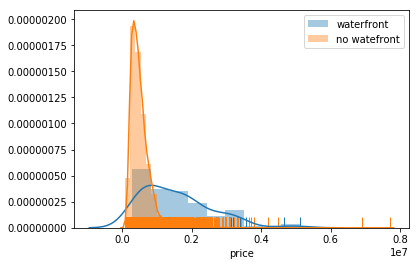

In [49]:
has_waterfront = X_train[X_train['waterfront'] == 1]
doesnt_have_waterfront = X_train[X_train['waterfront'] == 0]
sns.distplot(has_waterfront['price'], kde = True, rug = True, label = 'waterfront')
sns.distplot(doesnt_have_waterfront['price'], kde = True, rug = True, label = 'no watefront')
plt.legend()

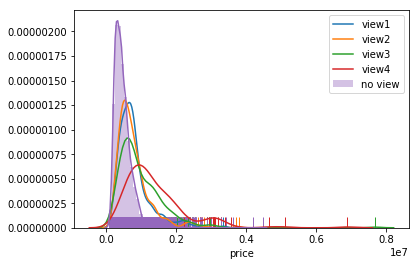

In [50]:
view1 = X_train[X_train['view'] == 1]
view2 = X_train[X_train['view'] == 2]
view3 = X_train[X_train['view'] == 3]
view4 = X_train[X_train['view'] == 4]
doesnt_have_view = X_train[X_train['view'] == 0]
sns.distplot(view1['price'], kde = True, rug = True, hist = False, label = 'view1')
sns.distplot(view2['price'], kde = True, rug = True, hist = False, label = 'view2')
sns.distplot(view3['price'], kde = True, rug = True, hist = False, label = 'view3')
sns.distplot(view4['price'], kde = True, rug = True, hist = False, label = 'view4')
sns.distplot(doesnt_have_view['price'], kde = True, rug = True, label = 'no view')
plt.legend()

It appears in both cases that the prices of the houses with waterfront and houses with view respectively are higher on average as their respective distributions are shifted to the right of the distributions of prices associated with houses that don't have these properties.

In [51]:
zero_values = []
for i in range(len(X_train.columns)):
    if 0 in X_train[list(X_train.columns)[i]].value_counts().reset_index().iloc[:, 0]:
        zero_values.append(list(X_train.columns)[i])
zero_values #It appears that all these columns have zero values, let's examine them

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

These zero values are of particular concern in regards to the quantitative continuous values. I would like to explore the sqft_basement column as it has lots of zero values(could be because not all homes have basements).

In [52]:
X_train.head()
sqft_basement = X_train['sqft_basement'].value_counts().reset_index()
proportion_zero = sqft_basement['sqft_basement'].iloc[0]/sum(sqft_basement['sqft_basement'])
proportion_zero

0.6101519337016574

It appears that greater than 50% of homes(61.01%) either don't have a basement, or the values are not recorded. It is quite possible, however, given the magnitude of this percent, that the majority of homes don't have basements. Thus, it would be unwise to remove these zero values, as the lack thereof of a basement may be a predictor in house price.

620233.0529672276
485112.5973967176


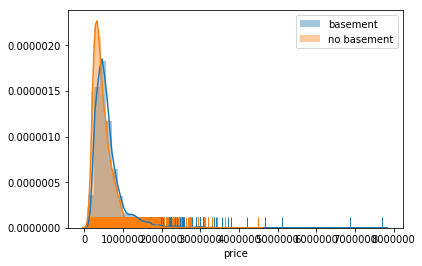

In [53]:
has_basement = X_train[X_train['sqft_basement'] != 0]
doesnt_have_basement = X_train[X_train['sqft_basement'] == 0]
sns.distplot(has_basement['price'], kde = True, rug = True, label = 'basement')
sns.distplot(doesnt_have_basement['price'], kde = True, rug = True, label = 'no basement')
plt.legend()
print(has_basement['price'].mean()) 
print(doesnt_have_basement['price'].mean())

It appears that the average price of homes who don't have basements is larger than the average price of homes that don't have basements. However, this is difficult to conclude, since there are very few houses that have basements, and what if it is due to random chance alone that more expensive houses happen to have basements?

In [54]:
def has_basement(basement):
    if basement == 0:
        return 0
    return 1

X_train['has_basement'] = X_train['sqft_basement'].apply(has_basement)
basements_table = X_train[['has_basement', 'price']].groupby('has_basement', as_index = False).agg(np.mean)
basements_table

,has_basement,price
0,0,485112.597397
1,1,620233.052967


In [55]:
observed_test_statistic = basements_table['price'].iloc[1] - basements_table['price'].iloc[0]
observed_test_statistic

135120.45557051006

In [56]:
X_train.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'has_basement'],
      dtype='object')

Null Hypothesis: The prices of homes that have basements and the prices of homes that do not have basements come from the same underlying distribution. The average price of homes that have basements is the same as the average price of homes that do not have basements.

Alternative Hypothesis: The prices of homes that have basements and the prices of homes that do not have basements come from different distributions. The average price of homes that have basements is greater than the average price of homes that do not have basements.

In [57]:
len(X_train.columns)

19

Text(0, 0.5, 'Percent per Average Price of Homes with basements minus Average price of homes without balconies.')

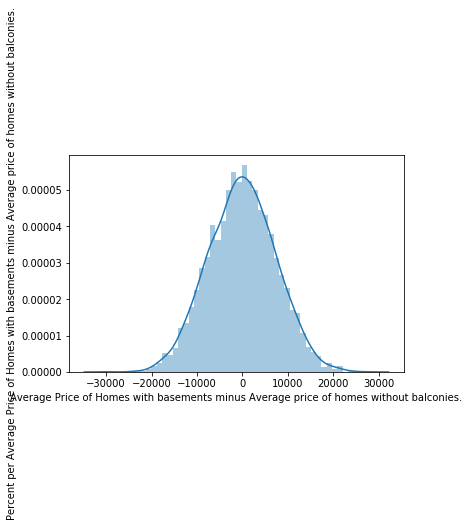

In [58]:
num_iterations = 5000
simulated_test_statistic_values = np.empty(num_iterations)
for i in np.arange(num_iterations):
    shuffled_basement = X_train.sample(len(X_train), replace = False).iloc[:, 18].to_frame().reset_index(drop=True)
    X_train['shuffled basement'] = shuffled_basement['has_basement']
    basements_table = X_train[['shuffled basement', 'price']].groupby('shuffled basement', as_index = False).agg(np.mean)
    simulated_test_statistic_value = basements_table['price'].iloc[1] - basements_table['price'].iloc[0]
    simulated_test_statistic_values[i] = simulated_test_statistic_value
    X_train = X_train.drop(columns = ['shuffled basement'])
    
simulated_test_statistic_values = pd.Series(simulated_test_statistic_values)
sns.distplot(simulated_test_statistic_values, kde = True)
plt.xlabel("Average Price of Homes with basements minus Average price of homes without balconies.")
plt.ylabel("Percent per Average Price of Homes with basements minus Average price of homes without balconies.")

In [59]:
p_value = np.count_nonzero(simulated_test_statistic_values >= observed_test_statistic)/len(simulated_test_statistic_values)
p_value

0.0

With a small p-value of 0.0, which is less than the p-value of 0.05, we reject the null hypothesis. There is sufficient evidence to conclude that the prices of homes that have basements and the prices of homes that do not have basements come from different distributions. The average price of homes that have basements is greater than the average price of homes that do not have basements. This demonstrates that even due to random chance alone, although the number of homes that have basements is quite small, according to this A/B test, it is unlikely that due to chance alone there would be such a significant difference in the averages.

In [60]:
X_train.head()
yr_renovated = X_train['yr_renovated'].value_counts().reset_index()
proportion_zero = yr_renovated['yr_renovated'].iloc[0]/sum(yr_renovated['yr_renovated'])
proportion_zero

0.9587016574585635

It appears that the vast majority of homes in this training set have not been renovated, or the potential renovations were not documented. We will come to know about how much these zero values will affect our prediction later in this process.

In [61]:
X_train['yr_renovated_modified'] = X_train['yr_renovated']
X_train.loc[X_train['yr_renovated_modified'] != 0, 'yr_renovated_modified'] = 1

In [62]:
yr_renovated_table = X_train[['yr_renovated_modified', 'price']].groupby('yr_renovated_modified', as_index = False).agg(np.mean)
yr_renovated_table

,yr_renovated_modified,price
0,0,528211.599986
1,1,760120.319398


Null Hypothesis: The prices of homes that are renovated and the prices of homes that are not renovated come from the same underlying distribution. The average price of homes that are renovated are the same as the average price of homes that are not renovated.

Alternative Hypothesis: The prices of homes that are renovated and the prices of homes that are not renovated come from different distributions. The average price of homes that are renovated is greater than the average price of homes that are not renovated.

In [63]:
observed_test_statistic = yr_renovated_table['price'].iloc[1] - yr_renovated_table['price'].iloc[0]
observed_test_statistic

231908.7194124004

In [64]:
X_train.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'has_basement', 'yr_renovated_modified'],
      dtype='object')

Text(0, 0.5, "Percent per Average Price of renovated homes minus Average price of homes that weren't renovated.")

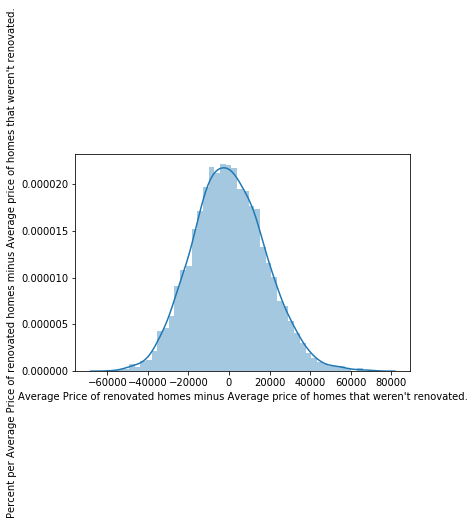

In [65]:
num_iterations = 5000
simulated_test_statistic_values = np.empty(num_iterations)
for i in np.arange(num_iterations):
    shuffled_renovated = X_train.sample(len(X_train), replace = False).iloc[:, 19].to_frame().reset_index(drop=True)
    X_train['shuffled renovated'] = shuffled_renovated['yr_renovated_modified']
    renovated_table = X_train[['shuffled renovated', 'price']].groupby('shuffled renovated', as_index = False).agg(np.mean)
    simulated_test_statistic_value = renovated_table['price'].iloc[1] - renovated_table['price'].iloc[0]
    simulated_test_statistic_values[i] = simulated_test_statistic_value
    X_train = X_train.drop(columns = ['shuffled renovated'])
    
simulated_test_statistic_values = pd.Series(simulated_test_statistic_values)
sns.distplot(simulated_test_statistic_values, kde = True)
plt.xlabel("Average Price of renovated homes minus Average price of homes that weren't renovated.")
plt.ylabel("Percent per Average Price of renovated homes minus Average price of homes that weren't renovated.")

In [66]:
p_value = np.count_nonzero(simulated_test_statistic_values >= observed_test_statistic)/len(simulated_test_statistic_values)
p_value

0.0

With a small p-value of 0.0, which is less than the p-value of 0.05, we reject the null hypothesis.The prices of homes that are renovated and the prices of homes that are not renovated come from different distributions. The average price of homes that are renovated is greater than the average price of homes that are not renovated.This demonstrates that even due to random chance alone, although the number of homes that are renovated is quite small, according to this A/B test, it is unlikely that due to chance alone there would be such a significant difference in the averages.

In [67]:
X_train

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,has_basement,yr_renovated_modified
16197,840000.0,4,2.75,2600,2750,1.5,0,0,3,7,1620,980,1936,0,47.6413,-122.357,1960,3705,1,0
16993,302000.0,3,2.50,2140,9492,2.0,0,0,3,8,2140,0,1994,0,47.3289,-122.204,2180,9184,0,0
17538,425000.0,4,1.75,1730,11890,1.0,0,0,2,7,980,750,1955,0,47.5979,-122.194,2100,12325,1,0
5761,215000.0,4,2.50,2130,4496,2.0,0,0,3,7,2130,0,2004,0,47.3041,-122.280,3220,5400,0,0
18921,565000.0,5,1.75,1910,9720,1.0,0,0,4,7,1390,520,1955,0,47.5772,-122.159,1750,9720,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,378000.0,3,1.50,1000,6914,1.0,0,0,3,7,1000,0,1947,0,47.7144,-122.319,1000,6947,0,0
21575,399950.0,3,2.50,3087,5002,2.0,0,0,3,8,3087,0,2014,0,47.2974,-122.349,2927,5183,0,0
5390,575000.0,3,2.50,2120,4780,2.0,0,0,3,7,2120,0,2004,0,47.6810,-122.032,1690,2650,0,0
860,245000.0,1,0.75,380,15000,1.0,0,0,3,5,380,0,1963,0,47.4810,-122.323,1170,15000,0,0


In [68]:
X_test

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
735,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,...,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
2830,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,...,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
4106,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,...,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
16218,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,...,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
19964,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,...,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15257,100500020,20140911T000000,250000.0,3,2.50,1610,6600,2.0,0,0,...,7,1610,0,1994,0,98003,47.2827,-122.302,1660,7689
13822,1523089266,20140722T000000,447500.0,3,2.50,2320,15024,2.0,0,0,...,8,2320,0,1990,0,98045,47.4829,-121.766,2300,15145
18411,3693901105,20141020T000000,630000.0,4,2.00,1610,5000,2.0,0,0,...,7,1610,0,1946,0,98117,47.6775,-122.398,1300,4950
20188,4083306552,20150310T000000,602000.0,3,3.25,1460,1367,3.0,0,0,...,8,1460,0,2008,0,98103,47.6485,-122.334,1310,1191


# Model Development Phase

Least Squares Linear Regression

In [69]:
def mse(actual, predicted):
    return np.mean((actual-predicted)**2)

In [70]:
import numpy as np
from sklearn.linear_model import LinearRegression
price = X_train['price'] #storing the price column in another variable
X_trained = X_train.loc[:, 'bedrooms': 'sqft_lot15']
y_trained = price
reg = LinearRegression()
reg = reg.fit(X_trained, y_trained)
reg.coef_

array([-3.09270300e+04,  4.29241333e+04,  1.06346589e+02,  1.01882479e-01,
        2.83920840e+03,  5.27027219e+05,  5.27584304e+04,  2.75452817e+04,
        9.54936590e+04,  6.83937979e+01,  3.79527909e+01, -2.45098797e+03,
        2.32574587e+01,  5.54560782e+05, -9.79817416e+04,  2.58085467e+01,
       -3.50773269e-01])

Cross validation accuracy to estimate the error on the test set. We are using k fold cross validation accuracy.

In [71]:
# from sklearn.model_selection import cross_val_score
# from sklearn import metrics
# training_scores = cross_val_score(reg, X_train, y_train, cv=5)
# print(training_scores)
def cross_validation_regression(k, X_train, y_train, loss_func):
    train_subset = 0
    test_subset = 0
    k_loss_metrics = []
    for i in range(k):
        random_number = np.random.randint(1000000, size=1)[0]
        print(random_number)
        train_subset = X_train.sample(frac = (1/k), replace = True, random_state = random_number)
        test_subset = y_train.sample(frac=(1/k), replace=True, random_state = random_number)
        actual = test_subset
        predicted = reg.predict(train_subset)
        k_loss_metrics.append(loss_func(actual, predicted))
    print(k_loss_metrics)
    return np.mean(k_loss_metrics)

cross_validation_regression(5, X_trained, y_trained, mse)

175471
794197
344252
203730
752587
[37965038328.23926, 39952731436.302376, 38960390068.89652, 40383140046.991165, 42831555948.276146]


40018571165.7411

Finally, we will use our test set to evaluate the performance of our model, using mean squared error.

In [91]:
the_price = X_test['price'] #storing the price column in another variable
X_tested = X_test.drop(columns = ['zipcode'])
X_tested = X_tested.loc[:, 'bedrooms': 'sqft_lot15']
y_tested = the_price
predictions = reg.predict(X_tested)
mse(y_tested, predictions)

46119662124.7352

In [94]:
reg.predict(X_tested.iloc[1:2, :]) #Creates a dataframe with one row

array([772374.3753925])

794406
678519
351696
298495
710177
[45471020361.74839, 37803533830.01449, 41842666840.24427, 39035675961.535866, 33349155894.16661]


Text(0.5, 1.0, 'Model')

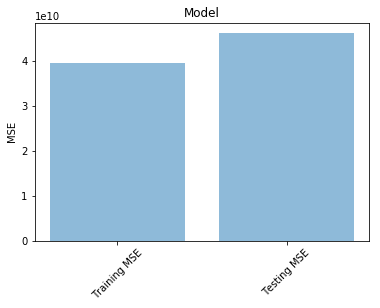

In [96]:
objects = ('Training MSE', 'Testing MSE')
y_pos = np.arange(len(objects))
performance = [cross_validation_regression(5, X_trained, y_trained, mse), mse(y_tested, predictions)]
plt.bar(y_pos, performance, align='center', alpha=0.5) 
plt.xticks(y_pos, objects)
plt.xticks(rotation= 45)
plt.ylabel('MSE')
plt.title('Model')

It appears that the testing MSE is larger than the training MSE, which makes sense since any particular model will likely overfit to the training dataset, but would generalize somewhat poorly to unseen data in the test set(to some degree). Particularly, with 18 features being used to predict the response variable(label), which is the house price, with a relatively high model complexity, would capture more noise in the data and be likely to overfit to the training data and not generalize well to unseen data. In such a situation, the model would have low bias(fits well to training data), but high variance(in some cases the accuracy on the test set would be high, and in other cases it may be low). However, this particular least squares regression model seems to generalize reasonably well to the test data for a relatively large number of features, as there isn't much of a difference between the training MSE and the test MSE in the bar chart above.

In conclusion, the least squares regression model received an MSE of 46119662124.7352 on the test set and MSE 40018571165.7411 on the training set with k-fold cross validation accuracy of 10 as k, for predicting house price in dollars. Thus, these models(after further testing with unseen data) will likely be used in a production environment. We must proceed with caution however, as trends in the factors that affect house prices may change over time, so we will need to update the model with new data over time to make these predictions align with the trends. Additionally, investigation into potential model drift over time should be examined, and should be trained with new and updated data.